# Bank Marketing Project

## Project Description:
The project (Code) analyzes the prior marketing campaign data of a Portugeuse bank and aims to predict whether the customer will subscribe to fixed-term deposit products the bank is offering. The code cleans the data, imputes the missing values, and analyzes and compares different predictive models. The best predictive model is used for the prediction exercise.

Comments and Explanations (in the form of Markdown) are included in the notebook to improve the readability of the code, to explain the rationale of doing certain steps and to discuss the results and inferences from the executed code.

The project was carried out as a part of course requirement of DS-GA:1007 Programming for Pyhton.

In [28]:
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV

In [2]:
df=pd.read_csv("bank-additional-full.csv",sep=';')
df=df.drop(['duration'],axis=1)
print(df.shape)
df.head()

(41188, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


We have dropped the 'duration' variable as the value of the variable will only be known at the end of the call. Hence, at that time we will also know the outcome of the call. The 'duration' variable will lead to leakage in the data and the prediction model will not be realistic.

# Exploratory Analysis:

## Categorical Variables:

We first start the exploratory analysis of the categorical variables and see what are the categories and are there any missing values for these categories. Here, we used the seaborn package to create the bar graphs below.

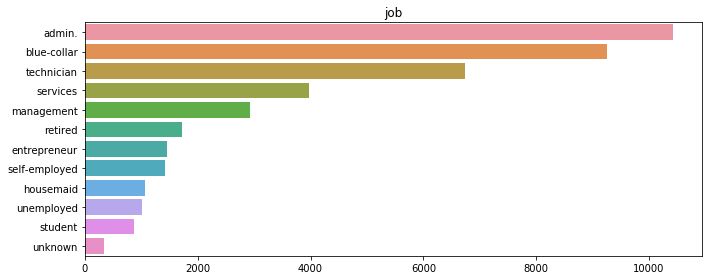

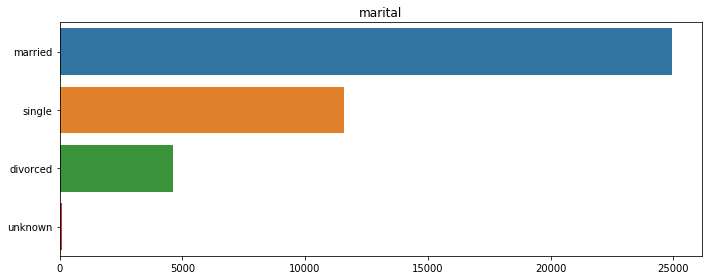

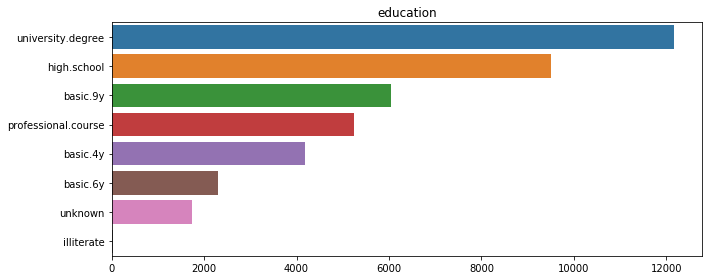

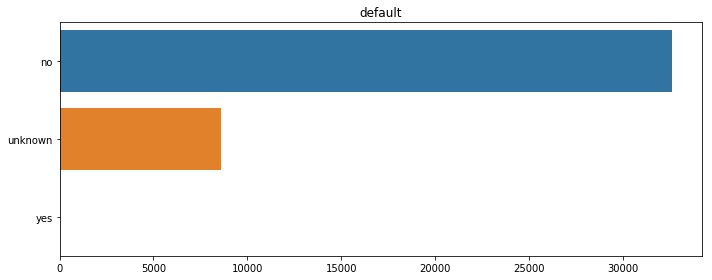

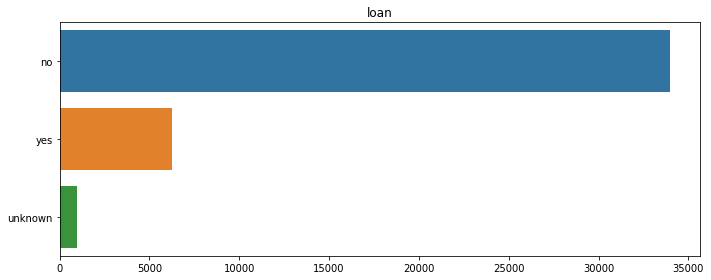

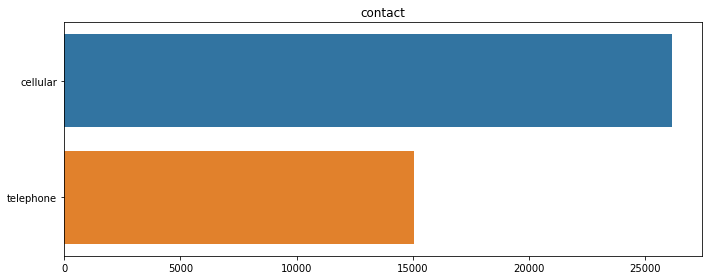

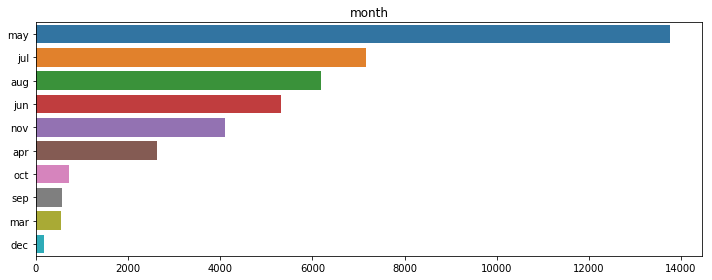

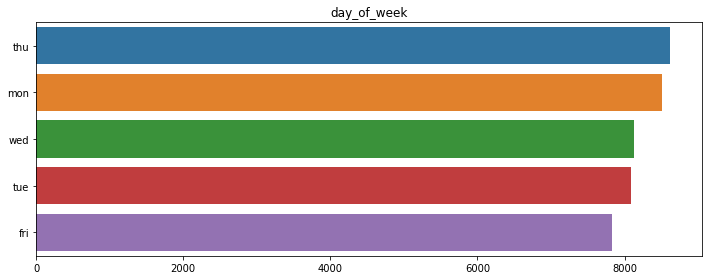

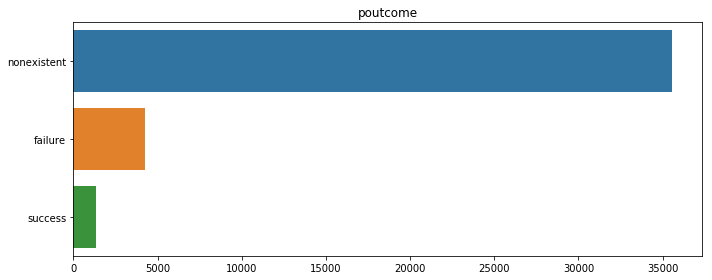

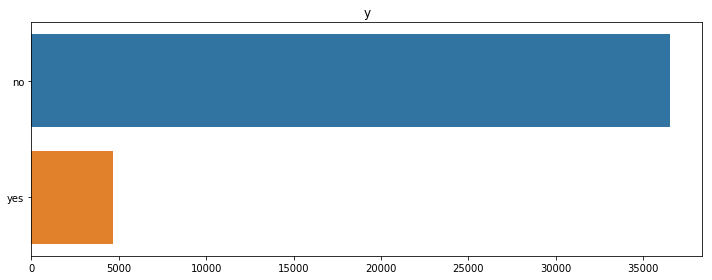

In [3]:
categorcial_variables = ['job', 'marital', 'education', 'default', 'loan', 'contact', 'month', 'day_of_week', 'poutcome','y']
for col in categorcial_variables:
    plt.figure(figsize=(10,4))
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()


## List of normalized relative frequency of the target class per category. 

Normalized distribution of each class per feature and plotted difference between positive and negative frequencies. Positive values imply this category favors clients that will subscribe and negative values categories that favor not buying the product.

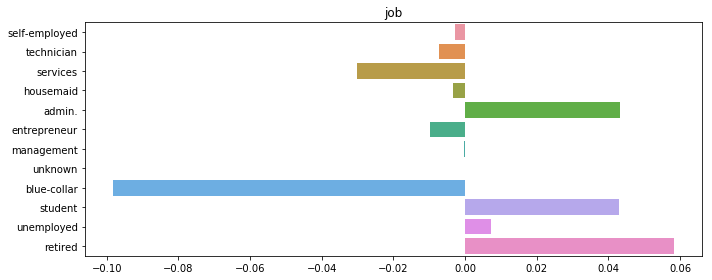

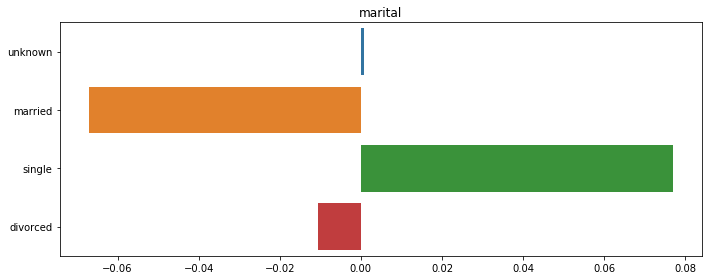

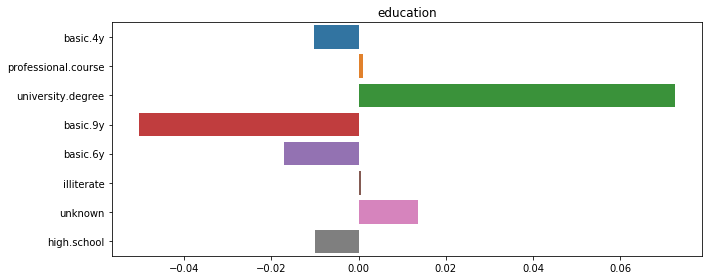

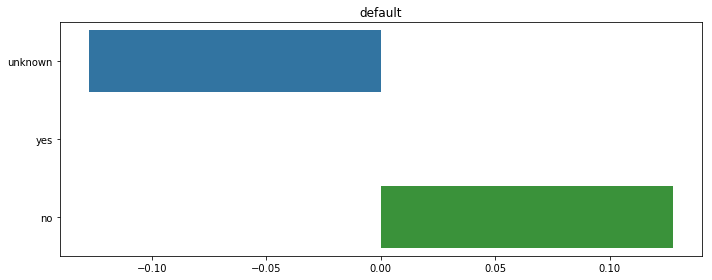

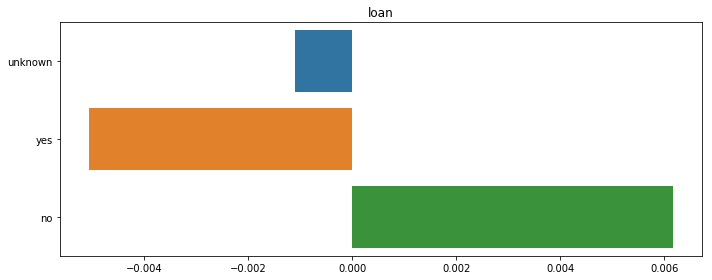

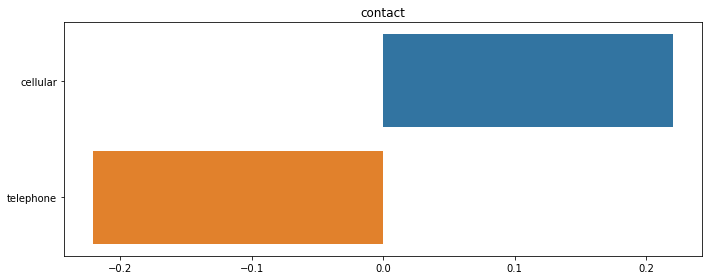

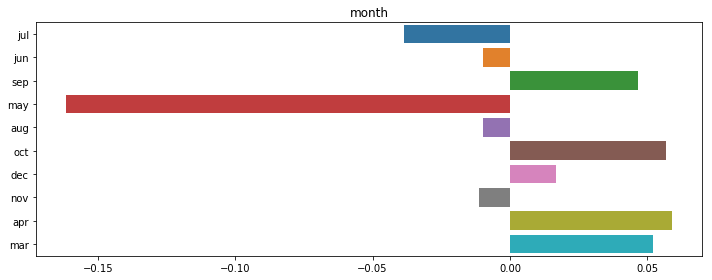

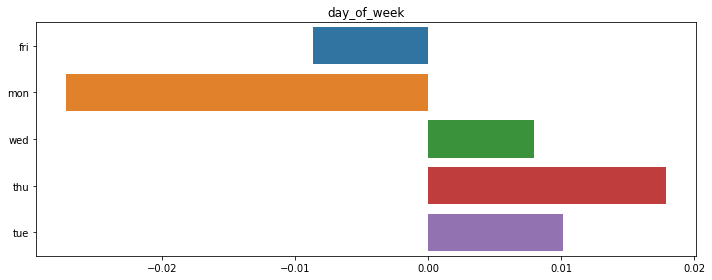

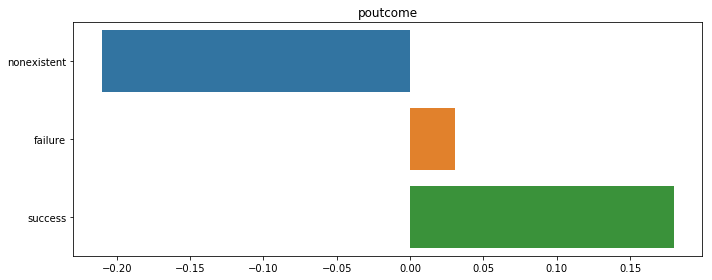

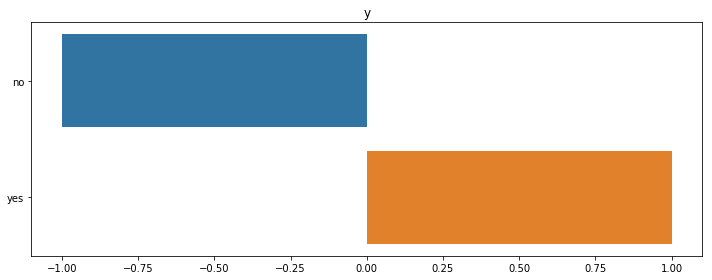

In [4]:
categorcial_variables = ['job', 'marital', 'education', 'default', 'loan', 'contact', 'month', 'day_of_week', 'poutcome','y']
for col in categorcial_variables:
    plt.figure(figsize=(10,4))
    #Returns counts of unique values for each outcome for each feature.
    pos_counts = df.loc[df.y.values == 'yes', col].value_counts() 
    neg_counts = df.loc[df.y.values == 'no', col].value_counts()
    
    all_counts = list(set(list(pos_counts.index) + list(neg_counts.index)))
    
    #Counts of how often each outcome was recorded.
    freq_pos = (df.y.values == 'yes').sum()
    freq_neg = (df.y.values == 'no').sum()
    
    pos_counts = pos_counts.to_dict()
    neg_counts = neg_counts.to_dict()
    
    all_index = list(all_counts)
    all_counts = [pos_counts.get(k, 0) / freq_pos - neg_counts.get(k, 0) / freq_neg for k in all_counts]

    sns.barplot(all_counts, all_index)
    plt.title(col)
    plt.tight_layout()

**Inference/Result**: There are unknown values for many variables in the Data set. There are many ways to handle missing data. One of the ways is to discard the row but that would lead to reduction of data set and hence would not serve our purpose of building an accurate and realistic prediction model.

Other method is to smartly infer the value of the unknown variable from the other variables. This a way of doing an imputation where we use other independent variables to infer the value of the missing variable. This doesn't gurantee that all missing values will be addressed but majority of them will have a reasonable which can be useful in the prediction. 

Variables with unknown/missing values are : 'education', 'job', 'housing', 'loan', 'deafult', and 'marital'. But the significant ones are 'education', 'job', 'housing', and 'loan'. The number of unknowns  for 'marital' is very low. The unknown for 'default' variable are considered to be recorded as unknown. It may be possible that customer is not willing to disclose this information to the banking representative. Hence the unknown value in 'default' is actually a separate value.

Therefore, we start with creating new variables for the unknown values in 'education', 'job', 'housing' and 'loan'. We do this to see if the values are missing at random or is there a pattern in the missing values.

In [5]:
## Creating new variables (variable name + '_un') to capture the information if the missing values are at random or is there
## a pattern in the missing values.
significant_cat_variables = ['education','job','housing','loan']
for var in significant_cat_variables:
    #df[var + '_un'] = 0
    #df[var + '_un'][df[var]=='unknown'] = 1
    #FIXME one-line coding
    df[var + '_un'] = (df[var] == 'unknown').astype(int)

## Imputation:

Now, to infer the missing values in 'job' and 'education', we make use of the cross-tabulation between 'job' and 'education'. Our hypothesis here is that 'job' is influenced by the 'education' of a person. Hence, we can infer 'job' based on the education of the person. Moreover, since we are just filling the missing values, we are not much concerned about the causal inference. We, therefore, can use the job to predict the education.

In [6]:
def cross_tab(df,f1,f2):
    jobs=list(df[f1].unique())
    edu=list(df[f2].unique())
    dataframes=[]
    for e in edu:
        dfe=df[df[f2]==e]
        dfejob=dfe.groupby(f1).count()[f2]
        dataframes.append(dfejob)
    xx=pd.concat(dataframes,axis=1)
    xx.columns=edu
    xx=xx.fillna(0)
    return xx

In [7]:
cross_tab(df,'job','education')

,basic.4y,high.school,basic.6y,basic.9y,professional.course,unknown,university.degree,illiterate
admin.,77,3329,151,499,363,249,5753,1.0
blue-collar,2318,878,1426,3623,453,454,94,8.0
entrepreneur,137,234,71,210,135,57,610,2.0
housemaid,474,174,77,94,59,42,139,1.0
management,100,298,85,166,89,123,2063,0.0
retired,597,276,75,145,241,98,285,3.0
self-employed,93,118,25,220,168,29,765,3.0
services,132,2682,226,388,218,150,173,0.0
student,26,357,13,99,43,167,170,0.0
technician,58,873,87,384,3320,212,1809,0.0


In [8]:
df['job'][df['age']>60].value_counts()

retired          678
housemaid         54
admin.            47
technician        34
management        30
unknown           21
blue-collar       20
self-employed      9
entrepreneur       8
unemployed         7
services           2
Name: job, dtype: int64

** Inferring education from jobs **: From the cross-tabulation, it can be seen that people with management jobs usually have a university degree. Hence wherever 'job' = management and 'education' = unknown, we can replace 'education' with 'university.degree'. Similarly, 'job' = 'services' --> 'education' = 'high.school' and 'job' = 'housemaid' --> 'education' = 'basic.4y'.

** Inferring jobs from education **: If 'education' = 'basic.4y' or 'basic.6y' or 'basic.9y' then the 'job' is usually 'blue-collar'. If 'education' = 'professional.course', then the 'job' = 'technician'.

** Inferring jobs from age**: As we see, if 'age' > 60, then the 'job' is 'retired,' which makes sense.

While imputing the values for job and education, we were cognizant of the fact that the correlations should make real world sense. If it didn't make real world sense, we didn't replace the missing values.

In [9]:
df.loc[(df['age']>60) & (df['job']=='unknown'), 'job'] = 'retired'
df.loc[(df['education']=='unknown') & (df['job']=='management'), 'education'] = 'university.degree'
df.loc[(df['education']=='unknown') & (df['job']=='services'), 'education'] = 'high.school'
df.loc[(df['education']=='unknown') & (df['job']=='housemaid'), 'education'] = 'basic.4y'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.4y'), 'job'] = 'blue-collar'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.6y'), 'job'] = 'blue-collar'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.9y'), 'job'] = 'blue-collar'
df.loc[(df['job']=='unknown') & (df['education']=='professional.course'), 'job'] = 'technician'

In [10]:
cross_tab(df,'job','education')

,basic.4y,high.school,basic.6y,basic.9y,professional.course,unknown,university.degree,illiterate
admin.,77.0,3329,151.0,499.0,363.0,249.0,5753,1.0
blue-collar,2366.0,878,1448.0,3654.0,453.0,454.0,94,8.0
entrepreneur,137.0,234,71.0,210.0,135.0,57.0,610,2.0
housemaid,516.0,174,77.0,94.0,59.0,0.0,139,1.0
management,100.0,298,85.0,166.0,89.0,0.0,2186,0.0
retired,601.0,276,75.0,145.0,243.0,112.0,286,3.0
self-employed,93.0,118,25.0,220.0,168.0,29.0,765,3.0
services,132.0,2832,226.0,388.0,218.0,0.0,173,0.0
student,26.0,357,13.0,99.0,43.0,167.0,170,0.0
technician,58.0,873,87.0,384.0,3330.0,212.0,1809,0.0


As we can see, we are able to reduce the number of unknowns and enhance our data set.

In [11]:
jobhousing=cross_tab(df,'job','housing')
jobloan=cross_tab(df,'job','loan')

** Imputations for house and loan **: We are again using cross-tabulation between 'house' and 'job' and between 'loan' and 'job.' Our hypothesis is that housing loan status (Yes or No) should be in the proportion of each job category. Hence using the prior known distribution of the housing loan for each job category, the house loan for unknown people will be predicted such that the prior distribution (% House = Yes's and No's for each job category remains the same). Similarly, we have filled the missing values in the 'loan' variable. 

In [12]:
def fillhousing(df,jobhousing):
    """Function for imputation via cross-tabulation to fill missing values for the 'housing' categorical feature"""
    jobs=['housemaid','services','admin.','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student']
    house=["no","yes"]
    for j in jobs:
        ind=df[np.logical_and(np.array(df['housing']=='unknown'),np.array(df['job']==j))].index
        mask=np.random.rand(len(ind))<((jobhousing.loc[j]['no'])/(jobhousing.loc[j]['no']+jobhousing.loc[j]['yes']))
        ind1=ind[mask]
        ind2=ind[~mask]
        df.loc[ind1,"housing"]='no'
        df.loc[ind2,"housing"]='yes'
    return df

In [13]:
def fillloan(df,jobloan):
    """Function for imputation via cross-tabulation to fill missing values for the 'loan' categorical feature"""
    jobs=['housemaid','services','admin.','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student']
    loan=["no","yes"]
    for j in jobs:
        ind=df[np.logical_and(np.array(df['loan']=='unknown'),np.array(df['job']==j))].index
        mask=np.random.rand(len(ind))<((jobloan.loc[j]['no'])/(jobloan.loc[j]['no']+jobloan.loc[j]['yes']))
        ind1=ind[mask]
        ind2=ind[~mask]
        df.loc[ind1,"loan"]='no'
        df.loc[ind2,"loan"]='yes'
    return df

In [14]:
df=fillhousing(df,jobhousing)

In [15]:
df=fillloan(df,jobloan)

##  Numerical variables:

Let see the summary of the data in order to understand the numerical variables.

In [16]:
numerical_variables = ['age','campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx','cons.conf.idx','euribor3m',
                      'nr.employed']
df[numerical_variables].describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


**Missing Values: **From the source of the data (U.C. Irvine ML Repository), we're told that the missing values, or NaNs, are encoded as '999'. From the above table, it is clear that only 'pdays' has missing values. Moreover, a majority of the values for 'pdays' are missing.

**Outliers:** Outliers are defined as 1.5 x Q3 value (75th percentile). From the above table, it can be seen that only 'age' and 'campaign' have outliers as max('age') and max('campaign') > 1.5*Q3('age') and >1.5*Q3('campaign') respectively.

But we also see that the value of these outliers are not so unrealistic (max('age')=98 and max('campaign')=56). Hence, we need not remove them since the prediction model should represent the real world. This improves the generalizability of the model and makes it robust for real world situations. The outliers, therefore, are not removed.


## Missing Values in Numerical Variables
Let's examine the missing values in 'pdays'

In [17]:
def drawhist(df,feature):
    plt.hist(df[feature])

Filtered out missing values encoded with an out-of-range value when plotting the histogram of values in order to properly understand the distribution of the known values. Here, histograms were created using matplotlib.

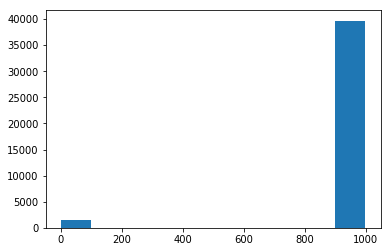

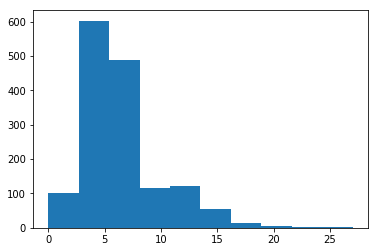

In [18]:
drawhist(df,'pdays')
plt.show()

plt.hist(df.loc[df.pdays != 999, 'pdays'])
plt.show()

In [19]:
pd.crosstab(df['pdays'],df['poutcome'], values=df['age'], aggfunc='count', normalize=True)

poutcome,failure,nonexistent,success
pdays,,,
0,0.000000,0.000000,0.000364
1,0.000000,0.000000,0.000631
2,0.000000,0.000000,0.001481
3,0.000097,0.000000,0.010561
4,0.000049,0.000000,0.002816
5,0.000097,0.000000,0.001020
6,0.000607,0.000000,0.009396
7,0.000364,0.000000,0.001093
8,0.000146,0.000000,0.000291


As we can see from the above table, the majority of the values for 'pdays' are missing. The majority of these missing values occur when the 'poutcome' is 'non-existent'. This means that the majority of the values in 'pdays' are missing because the customer was never contacted before. To deal with this variable, we removed the numerical variable 'pdays' and replaced it with categorical variables with following categories: p_days_missing, pdays_less_5, pdays_bet_5_15, and pdays_greater_15.

In [20]:
#Add new categorical variables to our dataframe.
df['pdays_missing'] = 0
df['pdays_less_5'] = 0
df['pdays_greater_15'] = 0
df['pdays_bet_5_15'] = 0
df['pdays_missing'][df['pdays']==999] = 1
df['pdays_less_5'][df['pdays']<5] = 1
df['pdays_greater_15'][(df['pdays']>15) & (df['pdays']<999)] = 1
df['pdays_bet_5_15'][(df['pdays']>=5)&(df['pdays']<=15)]= 1
df_dropped_pdays = df.drop('pdays', axis=1);

Since we have many categorical variables, dummy variables needs to be created for those vaiables. 

In [21]:
df_with_dummies=pd.get_dummies(df_dropped_pdays)

Drop one of the dummy variables as for $n$ categories we only need $n$-1 dummy variables.

In [22]:
def dropfeature(df,f):
    """Drops one of the dummy variables."""
    df=df.drop(f,axis=1)
    return df

In [23]:
features_dropped = ['default_no','housing_no','loan_no','y_no','marital_single','contact_cellular',
                    'education_unknown','job_unknown','housing_unknown','loan_unknown', 'pdays_less_5']
df_clean = dropfeature(df_with_dummies, features_dropped)

## Some helper functions to build and evaluate the models

In [24]:
def drawheatmap(df):
    '''Builds the heat map for the given data'''
    f, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(df.corr(method='spearman'), annot=False, cmap='coolwarm')
    
def drawhist(df,feature):
    '''Draws an histogram for a feature in a data frame (df)'''
    plt.hist(df[feature])

def functionreplace(df,fea,val1,val2):
    '''Replaces value (val1) with value (val2) in the data frame (df) for a feature (fea)'''
    df[fea].replace(val1,val2)
    return df

def drawbarplot(df,x,y):
    '''Draws a bar plot for a given feature x and y in a data frame'''
    sns.barplot(x=x, y=y, data=df)
    

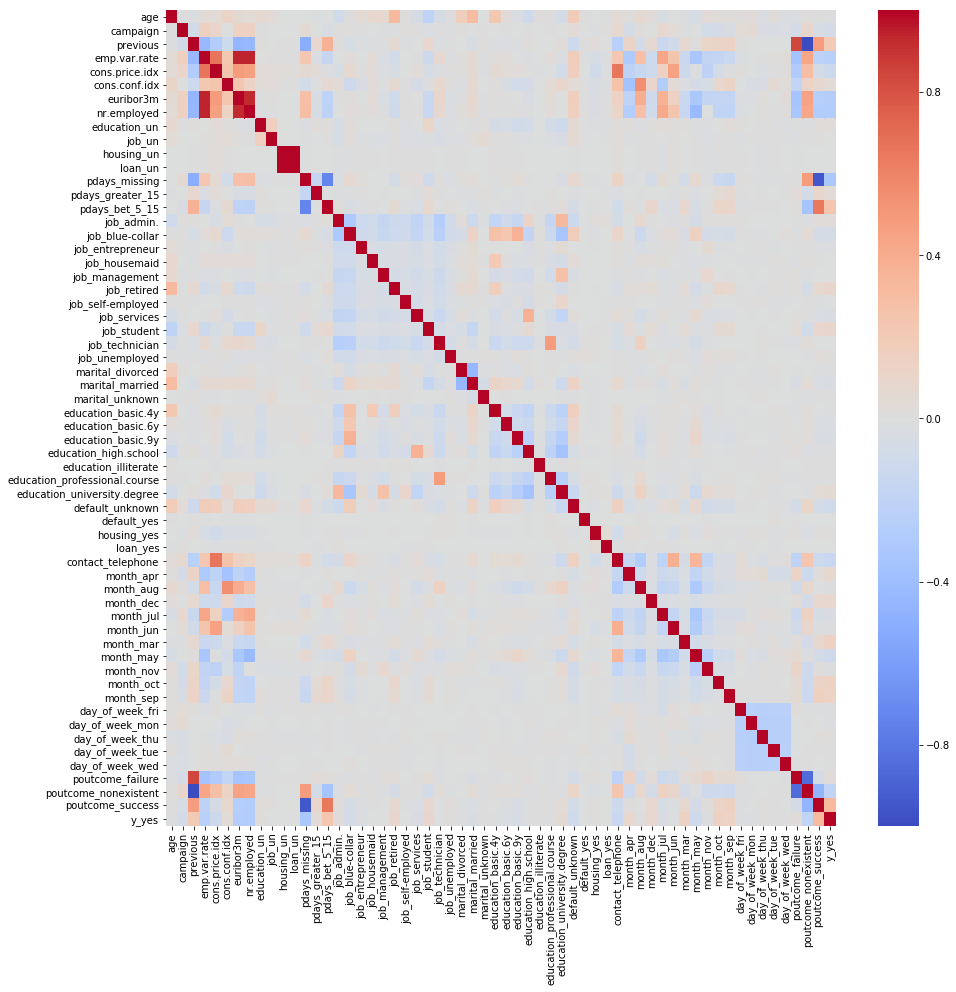

In [25]:
drawheatmap(df_clean)

**Inferences**: From the above heat map we can see that 'y_yes' (our target variable) has good correlation with **'previous', 'emp.var.rate', 'euribor3m', 'nr.employed', 'pdays_missing', 'poutcome_success' , 'poutcome_nonexistent'and 'pdays_bet_5_15'**. We expect to see these independent variables as significant while building the models.

In [91]:
def getmeanauc(aucs,model):
    ''' Calculates the mean AUC for all the cross-validated samples and computes the value of C (Regularization Parameter) 
    for which max mean auc is obtained'''
    #Initialize empty array to hold mean AUC values.
    meanauc = []
    maxmean = 0 #Initial value for maximum mean AUC
    models_with_1_param = ['Logistic_Regression' , 'Ada_Boost']
    models_with_2_params = ['Decision_Tree' , 'Random_Forest', 'Grad_Boost']
    for c in aucs: #For loop to append AUC value to meanauc array.
        meanauc.append(np.mean(aucs[c]))
        if maxmean < np.mean(aucs[c]):
            maxmean = np.mean(aucs[c]) #Adjust value of maxmean
            cval = c
    if model in models_with_1_param:
        print("C value for max auc is: ",cval)
        print("Max Mean Auc corresponding to the optimal value of C = ", maxmean)
        return meanauc,cval
    if model in models_with_2_params:
        listSL=cval.split('L')
        splitval=int(listSL[0]) #Stores minimum split value for max AUC
        leafval=int(listSL[1]) #Stores minimum leaf value for max AUC
        print("min_sample_split value for max auc is:",splitval)
        print("min_sample_leaf value for max auc is:",leafval)
        print("Max mean AUC corresponding to optimal leaf and split value = ",maxmean)
        return meanauc,splitval,leafval

def plot_mean_auc_LR(aucs,cs, label):
    '''Plots different values of mean auc versus the hyperparameter C'''
    plt.plot(np.log10(cs),aucs, label = label )
    plt.xlabel("C (Regularization Parameter)")
    plt.ylabel("Mean AUC")
    plt.legend()
        
def plotfeatureimportances(train, importance):
    '''Plots feature importance in a sorted order and shows the most significant variables at the top'''
    X = list(train.columns)
    X.remove('y_yes')
    feature_importance_df = pd.DataFrame(data = importance, index = X, columns=['coefficient_values'])
    feature_importance_df['sort'] = feature_importance_df.coefficient_values.abs()
    sorted_feature_imp_df = feature_importance_df.sort_values(by='sort', ascending=False).drop('sort', axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 15)
    sns.barplot(np.array(sorted_feature_imp_df.coefficient_values), np.array(sorted_feature_imp_df.index.values))
    plt.title('Feature Importances')
    plt.xlabel('Coefficients')
    plt.ylabel('Feature Names')
    
def plotfeatureimp(fl,col):
    '''Plots the feature importance of all the independent variables in the model'''
    f=plt.figure(figsize=(10,15))
    plt.barh(range(len(fl)),fl)
    plt.yticks(range(len(col[:-1])),col[:-1])
    
def plotAUCDTRF(aucs,leafs,splits):
    '''Plots AUC for each value of Leaf and Split combination'''
    for i in range(len(splits)):
        plt.plot(leafs,aucs[len(leafs)*i:len(leafs)*i+len(leafs)], label = 'Split value= ' + str(splits[i]))
    plt.legend()
    plt.xlabel('Leaf Values')
    plt.ylabel('Mean AUC')
    
def plot_mean_auc_Ada_Boost(aucs, estimators, label):
    '''Plots different values of mean auc versus the Estimators for AdaBoosting'''
    plt.plot(estimators,aucs, label = label )
    plt.xlabel("Estimators")
    plt.ylabel("Mean AUC")
    plt.legend()
        

# Model Building and Evaluation

**Train Test Split **: First we start with splitting the data into training and testing. For all the models, five-fold cross validation will be used.

Used stratification (keeping the target distribution unchanged) since dataset is highly imbalanced. A random train/test split will probably change the target distribution quite a bit.

In [92]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_clean, train_size=0.8, random_state=5)
print('Original:', (df_clean.y_yes).mean(), 'Train:', (train.y_yes).mean(), 'Test:', (test.y_yes).mean())

train, test = train_test_split(df_clean, train_size=0.8, stratify=df_clean.y_yes.values, random_state=5)
print('Original:', (df_clean.y_yes).mean(), 'Train:', (train.y_yes).mean(), 'Test:', (test.y_yes).mean())

Original: 0.112654171118 Train: 0.110682852807 Test: 0.120538965768
Original: 0.112654171118 Train: 0.112655538695 Test: 0.112648701141


## Logistic Regression Model
Here, we build the Logistic Regression model and evaluate it using the ROC curve and the AUC values. Since we know that the positive and the negative class are heavily imbalanced, the ROC curve and the AUC values are appropriate evaluation metrics as compared to the accuracy. For all the future models, the ROC curve and the AUC values are used as the evaluation metric.


In [62]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
def LRmodel(train , validate , c, l_1 = False):
    '''Fits the Logistic Regression Model on the training data set and calculates evaluation metrics on the validation set
    with the regularization constant C'''
    X=list(train.columns) #Create list of column labels from training data
    Y='y_yes'
    X.remove('y_yes')
    scaler = StandardScaler().fit(train[X]) #Standardize features by removing the mean and scaling to unit variance
    train_std = scaler.transform(train[X]) #Compute the mean and standard deviation on training set
    validate_std = scaler.transform(validate[X])
    xtrain = train_std
    ytrain = train[Y]
    xval = validate_std
    yval = validate[Y]
    if l_1:
        logreg = LogisticRegression(C = c, penalty= 'l1') #Apply logistic regression on L1 penalty
    else:
        logreg = LogisticRegression(C=c)
    logreg.fit(xtrain,ytrain)
    pred_proba_val = logreg.predict_proba(xval)[:,1]
    auc = metrics.roc_auc_score(yval, pred_proba_val)
    fpr, tpr, threshold = metrics.roc_curve(yval, pred_proba_val)
    accuracy = metrics.accuracy_score(yval, logreg.predict(xval))
    return auc,logreg.coef_, tpr, fpr, threshold, accuracy


## Cross-Validation and Tuning the hyperparameters for Logistic Regression:

Tuning of the models is done simulataneously with cross-validation. Tuning is basically done to decide the optimal regularization parameter for Logistic Regression and Linear SVM.


In [65]:
from sklearn.cross_validation import KFold
from sklearn import metrics
from sklearn import preprocessing

def kfoldlr(dataset , k , cs, l1_penalty = False):
    '''Performs kfold cross validation for the dataset and also searches for the optimal regularixation parameter '''
    aucs = {}
    kf = KFold(len(dataset),k) #Provides indices to split data in train/test sets
    for train_idx, vali_idx in kf: #For loop to extract and append AUC values to array from training data
        cv_train,cv_validate=dataset.iloc[train_idx,:], dataset.iloc[vali_idx,:]
        for c in cs:
            auc, f_imp, tpr, fpr, threshold, accuracy = LRmodel(cv_train,cv_validate,c, l_1 = l1_penalty)
            if c in aucs:
                aucs[c].append(auc)
            else:
                aucs[c]=[]
                aucs[c].append(auc)
    return aucs

The possible values of Cs (Regularization Parameter) are taken between $10^{-4}$ to $10^{5}$. 

In [66]:
cs = np.logspace(-4,5,10)
aucs_l2=kfoldlr(train , 5 , cs)
aucs_l1=kfoldlr(train , 5 , cs, l1_penalty= True)

In [68]:
means_l2,cval_l2 = getmeanauc(aucs_l2,'Logistic_Regression')
means_l1,cval_l1 = getmeanauc(aucs_l1,'Logistic_Regression')

C value for max auc is:  0.1
Max Mean Auc corresponding to the optimal value of C =  0.79007410954
C value for max auc is:  0.1
Max Mean Auc corresponding to the optimal value of C =  0.790285187028


**Inferences**: The Logistic regression is performing well and from the above run, its evident that LR is performing better with L1 regularization parameter than with L2 regularization parameter.

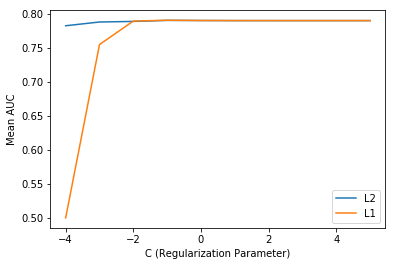

In [69]:
plot_mean_auc_LR(means_l2,cs, label = 'L2')
plot_mean_auc_LR(means_l1,cs, label = 'L1')

## Decision Tree Model

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
def DTmodel(train,validation,leaf=1,split=2):
    '''Decision Tree model to fit the train set to decision tree and predict AUC on test/validation set'''
    X=list(train.columns) #Create list of column labels from training data
    Y='y_yes'
    X.remove('y_yes')
    xtrain=train[X] 
    ytrain=train[Y]
    xval=validation[X]
    yval=validation[Y]
    
    #Runs sklearn's decision tree algorithm on the training data with min leaf size 1 and split size 2
    dt=DecisionTreeClassifier(criterion='entropy',min_samples_leaf=leaf,min_samples_split=split) 
    
    #Train the model
    dt.fit(xtrain,ytrain)
    predict_proba_val=dt.predict_proba(xval)[:,1] #Predict class probabilities of input validation data
    auc=metrics.roc_auc_score(yval,predict_proba_val) #Compute ROC AUC from prediction scores
    fpr,tpr,threshold=metrics.roc_curve(yval,predict_proba_val) #Compute ROC
    accuracy=metrics.accuracy_score(yval,dt.predict(xval)) #Compute subset accuracy classification score
    
    #Feature importances. The higher the score, the more important the feature. 
    #Computed as the normalized total reduction of the criterion brought by that feature.
    imp=dt.feature_importances_ 
    return auc,imp,tpr,fpr,threshold,accuracy

## Cross Validation and Hyper Parameter Tuning for Decision Tree:

In [1]:
from sklearn.cross_validation import KFold
from sklearn import metrics
from sklearn import preprocessing

def kfoldDTRF(dataset, k,split,leaf,model):
    '''K-fold validation function for Decision tree and Random Forest. K=5, hence input data set is divided 
    into 5 datasets out of which 4 of them will be used to fit model and one to validate the model in each iteration '''
    aucs={}
    kf=KFold(len(dataset),k) #Provides indices to split data in train/test sets
    for train_idx, vali_idx in kf: 
        cv_train,cv_validate=dataset.iloc[train_idx,:], dataset.iloc[vali_idx,:]
        for sp in split:
            for lf in leaf:
                if model=='DT':
                    #Run decision tree function above based on user input
                    core,fimp,tpr,fpr,threshold,accuracy=DTmodel(cv_train,cv_validate,lf,sp)
                if model=='RF':
                    #Run random forest function below based on user input
                    core,fimp,tpr,fpr,threshold,accuracy=randomforrest(cv_train,cv_validate,lf,sp)
                
                if str(sp)+"L"+str(lf) in aucs:
                    aucs[str(sp)+"L"+str(lf)].append(core)
                else:
                    aucs[str(sp)+"L"+str(lf)]=[]
                    aucs[str(sp)+"L"+str(lf)].append(core)
    return aucs


/Users/neelangparghi/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


min_sample_split_value and min_sample_leaf are hyper paremeters for Decision Tree and Random Forest indicating minimum split size and minimum leaf size. The range of value taken for split is [10,2000] and the range for leaf is [5,200]. Hence, there are 100 combination of split and leaf values. For each of these combinations, the AUC is calculated.

In [72]:
split = np.geomspace(10,2000,num=10,dtype=int)
leaf = np.geomspace(5,200,num=10,dtype=int)
aucsdt=kfoldDTRF(train,5,split,leaf,'DT')

min_sample_split value for max auc is: 1110
min_sample_leaf value for max auc is: 132
Max mean AUC corresponding to optimal leaf and split value =  0.791968413497


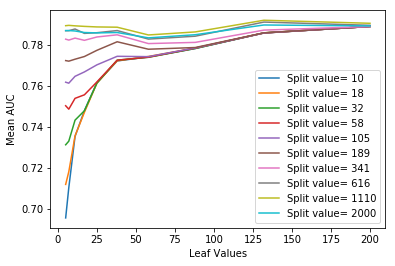

In [93]:
meanauc,splitval,leafval=getmeanauc(aucsdt,'Decision_Tree')
plotAUCDTRF(meanauc,leaf,split)

**Inference: **It's evident that the Decision Tree is performing slightly better than Logistic Regression.

## Random Forest Model

In [74]:
from sklearn.ensemble import RandomForestClassifier

def randomforrest(train,validation,leaf=1,split=2):
    '''Random Forest model to fit the training set to random forest and compute AUC on test/validation set'''
    X=list(train.columns) #Provides indices to split data in train/test sets
    Y='y_yes'
    X.remove('y_yes')
    xtrain=train[X]
    ytrain=train[Y]
    xval=validation[X]
    yval=validation[Y]
    
    #Run sklearn's random forest algorithm with 128 trees and a minimum split size of 2 and minimum leaf size 1
    random_forest = RandomForestClassifier(n_estimators=128,min_samples_split=split,min_samples_leaf=leaf)
    
    #Train the model
    random_forest.fit(xtrain,ytrain)
    
    #Predict target values
    Y_pred = random_forest.predict(xval)
    
    #Predict class probabilities of input validation data
    proba_val=random_forest.predict_proba(xval)[:,1]
    
    #Compute ROC
    fpr, tpr, thresholds=metrics.roc_curve(yval,proba_val)
    
    #Compute ROC AUC scores from prediction values
    score=metrics.roc_auc_score(yval,proba_val)
    
    #Feature importances. The higher the score, the more important the feature. 
    #Computed as the normalized total reduction of the criterion brought by that feature.
    importance=random_forest.feature_importances_
    accuracy=metrics.accuracy_score(yval,random_forest.predict(xval))
    return score,importance,tpr,fpr,thresholds,accuracy

## Cross Validation and Hyper Parameter Tuning for Random Forest:

min_sample_split_value and min_sample_leaf are hyper parameters for random forest indicating minimum split size and minimum leaf size. The range of value taken for split is [10,2000] and the range for leaf is [5,200]. hence, there are 100 combination of split and leaf values. For each of these combinations, the AUC is calculated.

In [75]:
RF_split = np.geomspace(10,2000,num=10,dtype=int)
RF_leaf = np.geomspace(5,200,num=10,dtype=int)

RF_auc=kfoldDTRF(train,5,RF_split,RF_leaf,'RF')

min_sample_split value for max auc is: 189
min_sample_leaf value for max auc is: 7
Max mean AUC corresponding to optimal leaf and split value =  0.797996817722


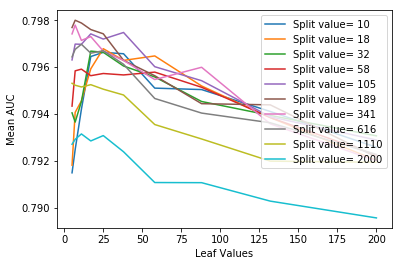

In [94]:
RF_aucs,RF_splitval,RF_leafval=getmeanauc(RF_auc,'Random_Forest')
plotAUCDTRF(RF_aucs,RF_leaf,RF_split)

**Inference**: It's evident that Random Forest is performing better than both the Logistic Regression and Decision Tree models.

## Gradient Boosting Model:

In [77]:
from sklearn.ensemble import GradientBoostingClassifier
def GBoosting(train,validation,leaf=1,split=2):
    """Function for gradient boosting to minimize loss via weak learners"""
    X=list(train.columns)
    Y='y_yes'
    X.remove('y_yes')
    xtrain=train[X]
    ytrain=train[Y]
    xval=validation[X]
    yval=validation[Y]
    
    GB = GradientBoostingClassifier(min_samples_split=split,min_samples_leaf=leaf)
    
    #Train the model
    GB.fit(xtrain,ytrain)
    
    #Predict target values
    Y_pred = GB.predict(xval)
    
    #Predict class probabilities of input validation data
    gbplot=GB.predict_proba(xval)
    gbpre=gbplot[:,1]
    
    #Compute ROC
    gbfpr, gbtpr, gbthresholds=metrics.roc_curve(yval,gbpre)
    
    #Compute ROC AUC scores from prediction values
    gbscore=metrics.roc_auc_score(yval,gbpre)
    gbaccuracy=metrics.accuracy_score(yval,GB.predict(xval))
    
    #Feature importances. The higher the score, the more important the feature. 
    importance=GB.feature_importances_
    
    return gbscore,importance,gbtpr,gbfpr,gbthresholds,gbaccuracy

## Cross Validation and Hyper Paremeter Tuning for Gradient Boosting: 

In [78]:
from sklearn.cross_validation import KFold
from sklearn import metrics
from sklearn import preprocessing
def kfoldGB(dataset, k,split,leaf):
    aucs={}
    kf=KFold(len(dataset),k) #Provides indices to split data in train/test sets
    for sp in split:
        for lf in leaf:
            for train_idx, vali_idx in kf:
                cv_train,cv_validate=dataset.iloc[train_idx,:], dataset.iloc[vali_idx,:]
                #Run Gradient Boosted Trees function defined above based on user input
                gbscore,importance,gbtpr,gbfpr,gbthresholds,gbaccuracy= GBoosting(cv_train,cv_validate,lf,sp)
                
                #Storing the AUC scores in the aucs dictionary for all split values (sp) and leaf values (lf)
                if str(sp)+"L"+str(lf) in aucs:
                    aucs[str(sp)+"L"+str(lf)].append(gbscore)
                else:
                    aucs[str(sp)+"L"+str(lf)]=[]
                    aucs[str(sp)+"L"+str(lf)].append(gbscore)
    return aucs

Gradient Boosting also takes split and leaf as hyper parameters. We are taking the range (10,2000) for split values and the range (5,2000) for leaf values to see which combination of gives the optimal AUC when Gradient Boosting is used.

In [108]:
gbsplit = np.geomspace(10,1500, num=8, dtype=int)
gbleaf = np.geomspace(5,750, num=6, dtype=int)
gbaucs=kfoldGB(train,5,gbsplit,gbleaf)

min_sample_split value for max auc is: 85
min_sample_leaf value for max auc is: 37
Max mean AUC corresponding to optimal leaf and split value =  0.800653715711


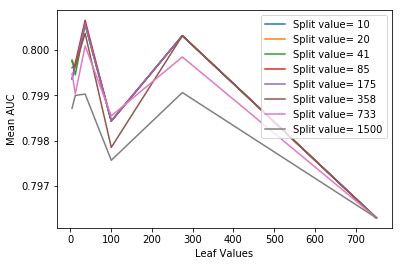

In [109]:
gbauc,gbsplitval,gbleafval=getmeanauc(gbaucs,'Grad_Boost')
plotAUCDTRF(gbauc,gbleaf,gbsplit)

**Inference: ** We see from the above output that Gradient Boosting performs better than Logistic Regression, Decision Tree, and Random Forest.

## Ada Boost Model 

In [96]:
from sklearn.ensemble import AdaBoostClassifier

In [97]:
def adaboost(settrain,settest, nestimator = 100):
    X=list(settrain.columns)
    Y='y_yes'
    X.remove('y_yes')
    xtrain=settrain[X]
    ytrain=settrain[Y]
    xtest=settest[X]
    ytest=settest[Y]
    #Instantiate a Decision Stump
    dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
    
    #Instantitate an AdaBoostClassifier using the decision stump defined above
    ad = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=nestimator)
    
    #fit the AdaBoostClassifier on the training data
    ad.fit(xtrain,ytrain)
    
    #Predict the Y values for the test/validation data
    Y_pred = ad.predict(xtest)
    
    #Predict class probabilities of input validation data
    adplot=ad.predict_proba(xtest)
    
    
    adpre=adplot[:,1]
    
    #Computation to compute AUC score
    adfpr, adtpr, adthresholds=metrics.roc_curve(ytest,adpre)
    adscore=metrics.roc_auc_score(ytest,adpre)
    
    #Feature importances. The higher the score, the more important the feature.
    ii=ad.feature_importances_
    return adscore,ii

## Cross Validation and Hyper Parameter Tuning for Adaboost Model: 

In [98]:
from sklearn.cross_validation import KFold
from sklearn import metrics
from sklearn import preprocessing
def kfoldadaboost(dataset, k, estimators):
    aucs ={}
    kf=KFold(len(dataset),k) #Provides indices to split data in train/test sets
    for e in estimators:
        for train_idx, vali_idx in kf:
            cv_train,cv_validate=dataset.iloc[train_idx,:], dataset.iloc[vali_idx,:]
            
            #Run AdaBoostClassifier function defined above based on user input
            core,f= adaboost(cv_train,cv_validate, nestimator = e) 
            
            #storing the auc Scores in the aucs dictionary for all the estimator values.
            aucs[e] = []
            aucs[e].append(core)
    return aucs

For Adaboost, n_estimators is the hyper parameter which corresponds to maximum number of estimators. we are taking the range of values (50,2000) to see which of these values gives highest AUC when Adaboost is used

In [99]:
estimators = np.array([50,100,400,600,1000,2000])
adaauc = kfoldadaboost(train, 5, estimators)

C value for max auc is:  1000
Max Mean Auc corresponding to the optimal value of C =  0.815741466281


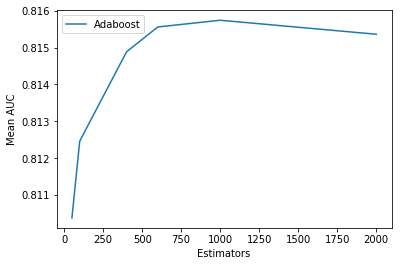

In [100]:
adaaucs,adac=getmeanauc(adaauc,'Ada_Boost')
plot_mean_auc_Ada_Boost(adaaucs,estimators,'Adaboost')

By comparing the mean AUC obtained by k-fold validation for each previous model, its clear that Adaboost is performing better than Logistic Regression, Decision Tree, Random Forest, and Gradient Boosting.
Hence, we select Adaboost with selected features as our final model and run it on the test set to make suggestions to the marketing team of Banco de Portugal to guide them in targeting optimal clients.

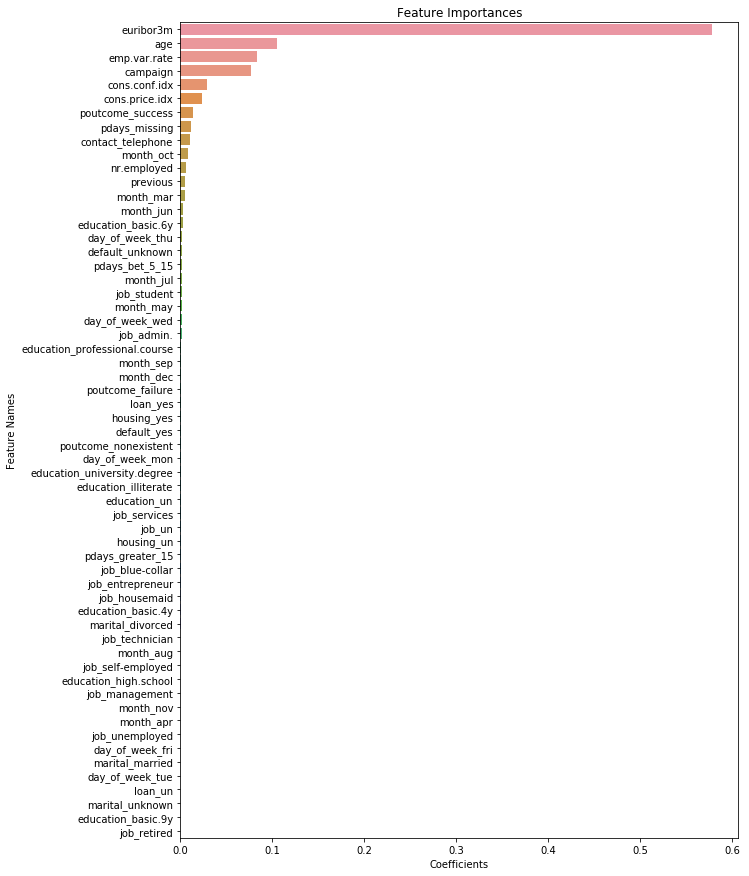

In [101]:
adaauc_test,adafea=adaboost(train,test,adac)
plotfeatureimportances(train,adafea)

In [103]:
print('Final Test AUC Score = ',adaauc_test)

Final Test AUC Score =  0.803608144842


From the above Feature Importance chart, we see that Europe's Libor rate ('euribor3m'), client age ('age'), employment variability index ('emp.var.rate'), number of client contacts during the current marketing campaign ('campaign'), consumer price index ('cons.price.idx'), consumer confidence index ('cons.price.idx'), and mode of contact via phone ('contact_telephone') are the imporatant features that drive the decision of the customer to purchase the term deposit or not. 